<a href="https://colab.research.google.com/github/saikumarbysani/PortFolioProject/blob/main/Deep_learning_Market_Size_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats
from scipy.stats import spearmanr
from scipy.stats.stats import f_oneway,F_onewayResult
from pandas import Series        # To work on series 
%matplotlib inline 
import warnings                   # To ignore the warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
#from pmdarima.arima import auto_arima

# these functions are useful for splitting and normalization
from sklearn.preprocessing import  MinMaxScaler
from sklearn.model_selection import train_test_split

# import other functions we'll need for regression modeling 
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# regression error metrics - scikit-learn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import scipy.stats

# regression error metrics - scikit-learn
from statsmodels.tools.eval_measures import rmse
from statsmodels.tools.eval_measures import mse
from statsmodels.tools.eval_measures import meanabs

# Some tests/statistics required for validating assumptions
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report,accuracy_score
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, GRU, LSTM
from tensorflow.keras.callbacks import EarlyStopping

### Multivariate forecasting

In [ ]:
df_deep=pd.read_excel("/content/drive/MyDrive/Lego/final_data_quantity_total.xlsx")

In [ ]:
df_deep.head()

,Unnamed: 0,Date,Market Volume,Personal_Saving,Saving_Rate,Disposable_Income,Toy_CPI,Personal_Expenditure,PPI,Inflation Rates,...,Unemp_state_Washington,Unemp_state_West Virginia,Unemp_state_Wisconsin,Unemp_state_Wyoming,Unemp_state_Puerto Rico,positive,negative,neutral,sales_qty,sales_nip
0,0.0,2017-01-01,1181.0,1000.5,6.9,13747.2,38.903,13020.4,91.7,2.5,...,4.8,5.4,3.5,4.8,11.8,1169.0,428.0,1404.0,3245862.0,42421716.96
1,1.0,2017-02-01,1180.0,1043.5,7.2,13783.4,38.728,13038.6,89.7,2.7,...,4.7,5.2,3.4,4.6,11.5,1224.0,354.0,1423.0,4191633.0,51423021.12
2,2.0,2017-03-01,1354.0,1047.1,7.2,13840.4,38.416,13089.3,90.7,2.4,...,4.6,5.1,3.3,4.4,11.2,1027.0,457.0,1517.0,4908765.0,62545641.48
3,3.0,2017-04-01,1277.0,1071.8,7.3,13864.5,38.057,13114.1,92.9,2.2,...,4.6,5.0,3.3,4.2,10.9,1014.0,420.0,1567.0,4212361.0,52991029.95
4,4.0,2017-05-01,1246.0,1157.0,7.8,13957.3,37.812,13117.6,92.9,1.9,...,4.6,5.0,3.2,4.1,10.6,1076.0,432.0,1493.0,3180010.0,44400646.34


In [ ]:
df_deep.Date=pd.to_datetime(df_deep.Date)

In [ ]:
df_deep['month']=df_deep['Date'].dt.month

In [ ]:
df_deep=df_deep.drop(['Unnamed: 0'],axis=1)

In [ ]:
df_new=df_deep[['Market Volume', 
       'month',
       'sales_qty']]

In [ ]:
# prep data for modeling (multivariate)

from numpy import array

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in np.arange(len(sequences)): # be careful of this line!
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [ ]:
# look back period
n_steps = 12
raw_seq = np.array(df_new) 
X, y = split_sequences(raw_seq, n_steps=12)

In [ ]:
print(X.shape)
print(y.shape)

(57, 12, 2)
(57,)


In [ ]:
# split the data into train and test partitions
# we will use 90% of the data for train, and 10% for validation
train_pct_index = int(0.9 * len(X))
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]

In [ ]:
# check the shape to be sure
print(X.shape, X_train.shape, X_test.shape)
print(y.shape, y_train.shape, y_test.shape)

(57, 12, 2) (51, 12, 2) (6, 12, 2)
(57,) (51,) (6,)


### modeling 

In [ ]:

# now let's build a model


n_features = X.shape[2] 
n_steps = X.shape[1] 

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=2, input_shape=(n_steps,n_features)))  
model.add(MaxPooling1D(2))
model.add(Conv1D(filters=64, kernel_size=2))  
model.add(MaxPooling1D(2)) 
model.add(SimpleRNN(15, return_sequences=True,activation='relu')) 
model.add((LSTM(120, return_sequences=True,activation='relu'))) 
model.add((GRU(100, return_sequences=True,activation='relu')))
model.add((LSTM(25,activation='relu', return_sequences=True))) 
model.add((SimpleRNN(15,activation='relu'))) 
model.add(Dense(1,activation='relu')) 
model.compile(optimizer='adam', loss='mae',metrics=['mse'])
model.summary()

es = EarlyStopping(monitor='val_loss', mode='min', 
                   patience=200, 
                   verbose=1,
                   restore_best_weights=True)

history=model.fit(X_train, y_train, 
          epochs=1200, 
          batch_size=1, 
          validation_split=0.2, # val is a random 20% of the train data since we set shuffle = True
          verbose=1,
          callbacks=[es],
          shuffle=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 11, 32)            160       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 5, 32)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 4, 64)             4160      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 2, 64)            0         
 1D)                                                             
                                                                 
 simple_rnn (SimpleRNN)      (None, 2, 15)             1200      
                                                                 
 lstm (LSTM)                 (None, 2, 120)            6

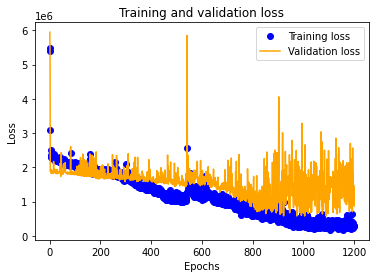

In [ ]:
# let's see the training and validation accuracy by epoch
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

2/2 [==============================] - 0s 9ms/step
Test MAE:  383614.25
Train rmse is  839885.8849799851
Test rmse is  433386.3896974135


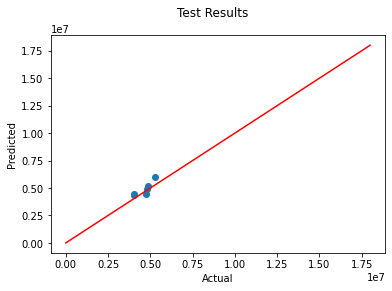

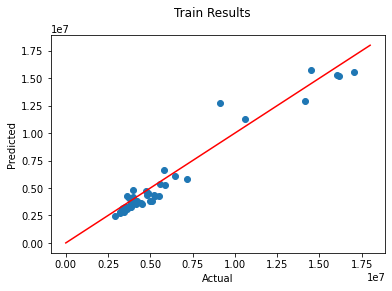

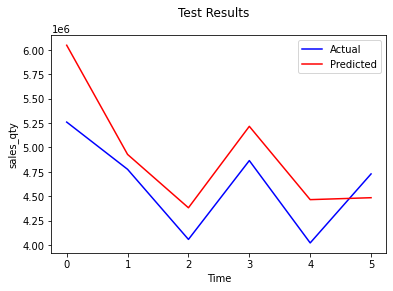

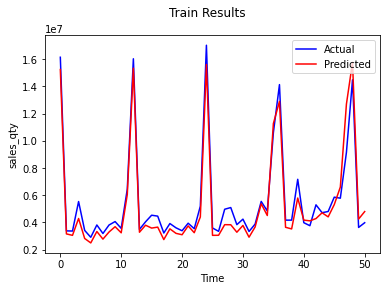

In [ ]:
# show scatterplots of actual vs. predicted for train and test
# make a prediction
pred = model.predict(X_test)# the pred
train_pred=model.predict(X_train)
from sklearn.metrics import mean_absolute_error
print('Test MAE: ', mean_absolute_error(y_test, pred))

rmse_train_deep=np.sqrt(mean_squared_error(y_train,train_pred))
print("Train rmse is ",rmse_train_deep)

rmse_test_deep=np.sqrt(mean_squared_error(y_test,pred))
print("Test rmse is ",rmse_test_deep)
actual = y_test 
plt.scatter(x=actual, y=pred)
x = np.linspace(0,18000000) 
plt.plot(x, x, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()


actual = y_train
plt.scatter(x=actual, y=train_pred)
x = np.linspace(0,18000000) 
plt.plot(x, x, color='red')
plt.suptitle('Train Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()


# show timeseries plot on the test and validation data
plt.figure(figsize = (6,4))
x = np.linspace(0,18000000)
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), pred, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('sales_qty')
plt.legend(['Actual','Predicted'])
plt.show()

# show timeseries plot on the train and validation data
plt.figure(figsize = (6,4))
x = np.linspace(0,18000000)
plt.plot(np.arange(X_train.shape[0]), y_train, color='blue') # actual data
plt.plot(np.arange(X_train.shape[0]), train_pred, color='red') # predicted data
plt.suptitle('Train Results')
plt.xlabel('Time')
plt.ylabel('sales_qty')
plt.legend(['Actual','Predicted'],loc='upper right')
plt.show()

In [ ]:
# from keras.models import load_model
# model.save("deep_learning_model.h5")

In [ ]:
# weights="deep_learning_model_weights.hdf5"
# model.save_weights(weights)